# **La classification**

Ce notebook est dédié au développement et à l'optimisation d'un modèle de classification automatique pour les produits d'un site du site **Place de marché**, en utilisant des images de produits. Suite à une étude de faisabilité confirmée sur les descriptions textuelles et les images, nous passons maintenant à la mise en œuvre et à l'évaluation de plusieurs architectures de **réseaux de neurones** pour améliorer la précision de notre système de classification.

Nous explorerons plusieurs étapes pour affiner notre modèle, notamment :

* **Utilisation de VGG16** : Nous débuterons avec VGG16, un modèle pré-entraîné bien connu pour la classification d'images. Ce modèle servira de base pour évaluer les performances initiales et orienter nos choix d'optimisation.

* **Augmentation des données** : Nous testerons des techniques d'augmentation de données pour enrichir notre ensemble de données d'entraînement, améliorant ainsi la diversité des images et rendant le modèle plus robuste face aux variations.

* **Optimisation de paramètres** : Nous ajustons des hyperparamètres essentiels tels que le taux d'apprentissage (learning rate) et le dropout pour tester leur impact sur la précision et la stabilité du modèle.

* **Expérimentation avec EfficientNet** : Enfin, nous expérimentons avec EfficientNet, une architecture de réseau de neurones plus récente et optimisée pour un compromis performant entre la précision et la complexité

**Importer les bibliothèques nécessaires**

In [ ]:
pip install numpy pandas scikit-learn

In [ ]:
!pip install plot_keras_history


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msn
import seaborn as sns
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from PIL import Image
from sklearn.manifold import TSNE
import cv2
import time
from sklearn import manifold, decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from plot_keras_history import show_history, plot_history
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, roc_curve
from tensorflow.keras.applications import EfficientNetB0


In [ ]:
# Afficher toutes les colonnes
pd.options.display.max_columns = None

In [ ]:
#chargement fichier pretraiter
data_texte = pd.read_csv('data_texte_cleaned.csv')

In [ ]:
# chargement fichier avec les categorie
data_texte = pd.read_csv('data_texte_with_categories.csv')

In [ ]:
# chargement fichier avec les categorie
data_texte = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [ ]:
data_texte[['Category_1', 'Category_2', 'Category_3']] = data_texte['product_category_tree'].str.strip('[]').str.replace('"', '').str.split('>>', n=3, expand=True)[[0, 1, 2]]

*Chargement des images*

In [ ]:
# Monter Google Drive
drive.mount('/content/drive')

# Spécifiez le chemin correct vers votre dossier d'images
file_path = '/content/drive/My Drive/image'

# Lister les fichiers dans le dossier
list_photos = [file for file in os.listdir(file_path) if file.endswith(('.png', '.jpg', '.jpeg'))]




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Création du modèle de classification**

In [ ]:
# Ne garder que les colonnes "image" et "Category_1"
data_texte = data_texte[['image', 'Category_1']]

# Diviser les données avec une répartition 80-20 pour l'entraînement et le test
data_train, data_test = train_test_split(data_texte, test_size=0.2, random_state=42)


In [ ]:
def create_model_fct():
    # Charger le modèle VGG16 pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Geler toutes les couches du modèle de base
    for layer in model0.layers:
        layer.trainable = False


    # Ajouter des couches personnalisées
    x = model0.output
    x = GlobalAveragePooling2D()(x) # réduit les dimensions de la sortie de VGG16 et en fait une représentation plus compacte
    x = Dense(256, activation='relu')(x) # ajoute une couche dense avec 256 unités et la fonction d'activation ReLU, pour introduire de la non-linéarité et apprendre des combinaisons complexes de caractéristiques.
    x = Dropout(0.5)(x) # désactivez aléatoirement 50 % des neurones lors de chaque itération d'entraînement, pour réduire le surapprentissage.


    # Mettre à jour la couche finale pour correspondre au nombre de classes (7)
    predictions = Dense(7, activation='softmax')(x) # le modèle est configuré pour classifier les images en 7 catégories.

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions) # Le modèle final est construit en connectant les entrées du modèle VGG16 aux nouvelles couches de sortie définies, formant ainsi un réseau de bout en bout.

    # Compiler le modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"]) # Le modèle est compilé en utilisant la fonction de perte categorical_crossentropy, qui est bien adaptée pour la classification multi-classes, avec rmspropcomme optimiseur, qui ajuste les poids du modèle pour minimiser la perte

    print(model.summary())  #  affiche la structure complète du modèle, et le modèle est ensuite retourné par la fonction.
    return model


In [ ]:
# Ne garder que les colonnes "image" et "Category_1
data = data_texte[['image', 'Category_1']]
data['image_path']=file_path+'/'+data_texte['image']
data=data.rename(columns={'Category_1':'label_name'})
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
le = LabelEncoder()
le.fit(data["label_name"])
data_train["label"] = le.transform(data_train["label_name"])
data_test["label"] = le.transform(data_test["label_name"])


data_train=data_train.reset_index()
data_test=data_test.reset_index()

In [ ]:
data_train

,index,image,label_name,image_path,label
0,554,b144a363c107c7bdd91f32d6e28ba6f2.jpg,Watches,/content/drive/My Drive/image/b144a363c107c7bd...,6
1,1012,29def171d7e31d48571a52f0fb3e6b07.jpg,Home Decor & Festive Needs,/content/drive/My Drive/image/29def171d7e31d48...,3
2,481,9f9bb0ef3bb8af571bcfbfa1a22150bd.jpg,Computers,/content/drive/My Drive/image/9f9bb0ef3bb8af57...,2
3,432,7f2f1f3039d1f5bc23226fc36577eab9.jpg,Computers,/content/drive/My Drive/image/7f2f1f3039d1f5bc...,2
4,626,73901494efea71869576898c68b5eee4.jpg,Home Furnishing,/content/drive/My Drive/image/73901494efea7186...,4
...,...,...,...,...,...
835,330,394c2c627914e1eed9b8ac343583a679.jpg,Computers,/content/drive/My Drive/image/394c2c627914e1ee...,2
836,466,3bc98543c7dd0d8fce5b8185b4a58c43.jpg,Baby Care,/content/drive/My Drive/image/3bc98543c7dd0d8f...,0
837,121,7dd5e83e2108a97659577e50879f9d9f.jpg,Baby Care,/content/drive/My Drive/image/7dd5e83e2108a976...,0
838,1044,be0f39341d771aac57084970f1ed6425.jpg,Baby Care,/content/drive/My Drive/image/be0f39341d771aac...,0


## préparation des images pour l'entraînement

In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data_train)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(840, 224, 224, 3)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [ ]:

# Préparation des labels avec les noms


# Préparation des données pour l'entraînement et le test
X = images_np  # Images d'entraînement
y = to_categorical(data_train['label'])  # Étiquettes d'entraînement, encodées en one-hot

X_test = images_np_test  # Images de test
y_test = to_categorical(data_test['label'])  # Étiquettes de test, encodées en one-hot

# Vérification des formes des données
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X shape: (840, 224, 224, 3)
y shape: (840, 7)
X_test shape: (210, 224, 224, 3)
y_test shape: (210, 7)


In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
# Diviser les données d'entraînement en sous-ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

*Images de chaque étiquette (classe)*

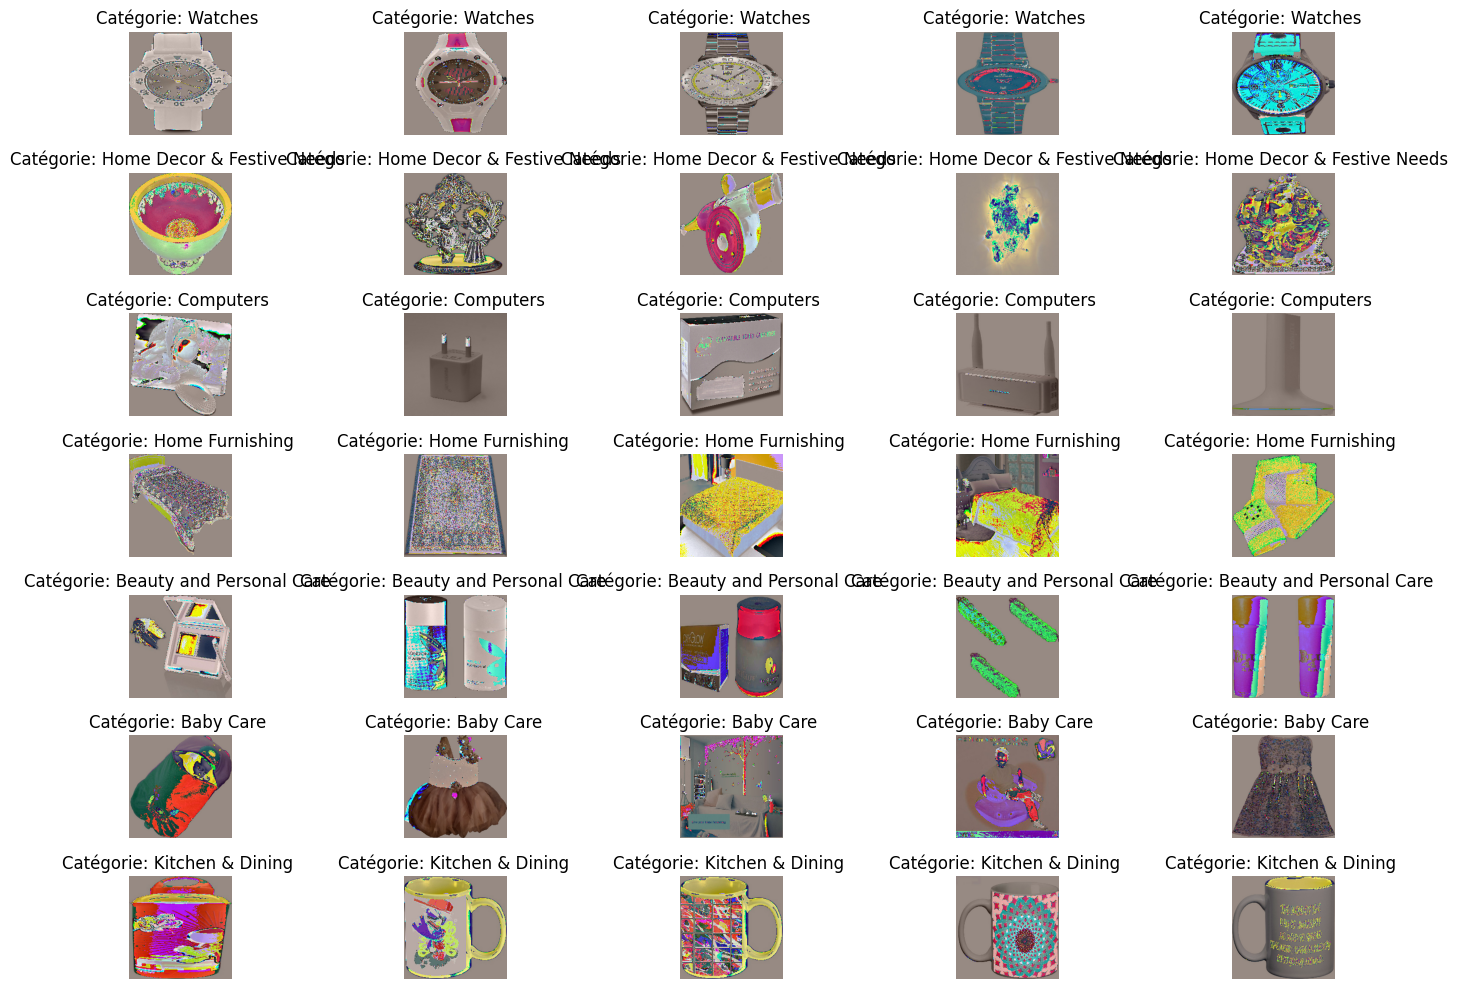

In [ ]:
def display_sample_images(data, images, num_samples=2):
    """
    Affiche quelques images pour chaque catégorie dans les données d'entraînement.

    :param data: DataFrame contenant les informations sur les images et les noms de catégorie.
    :param images: Tableau NumPy contenant les images prétraitées.
    :param num_samples: Nombre d'images à afficher par catégorie.
    """
    unique_categories = data['label_name'].unique()
    plt.figure(figsize=(15, 10))

    for i, category in enumerate(unique_categories):
        # Sélectionner les indices correspondant à cette catégorie
        category_indices = data[data['label_name'] == category].index
        selected_indices = np.random.choice(category_indices, size=num_samples, replace=False)

        for j, index in enumerate(selected_indices):
            plt.subplot(len(unique_categories), num_samples, i * num_samples + j + 1)
            plt.imshow(images[index].astype("uint8"))  # Convertit en format affichable
            plt.title(f"Catégorie: {category}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Utilisation de la fonction
display_sample_images(data_train, images_np, num_samples=5)


*Répartition des catégories*

<ipython-input-117-b508df8190cb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_train, x='label_name', palette='viridis')


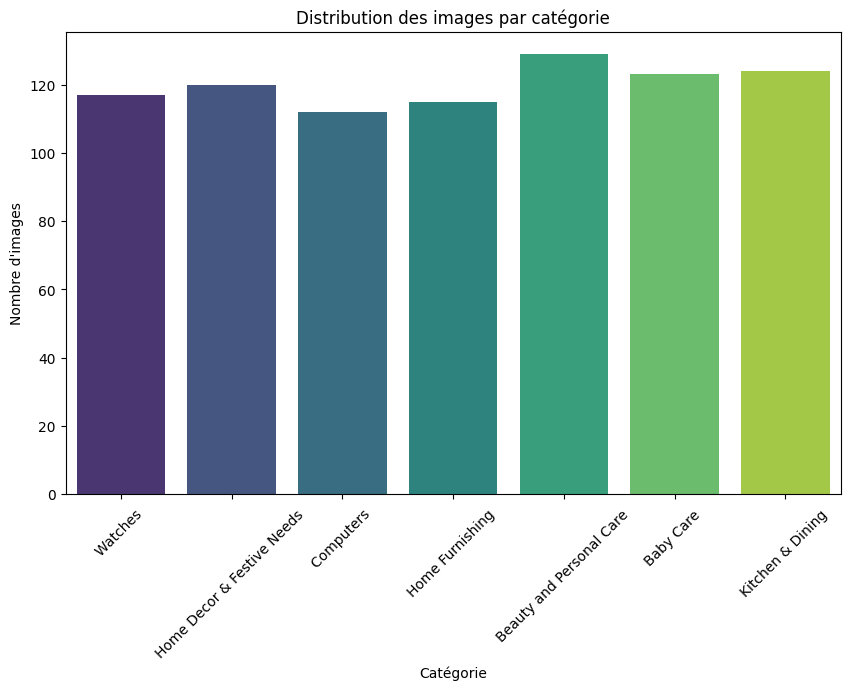

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data_train, x='label_name', palette='viridis')
plt.title("Distribution des images par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.keras"  # Changer l'extension en .keras
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]





Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:

num_classes = len(np.unique(data_train["label"]))
print("Number of unique classes:", num_classes)
predictions = Dense(7, activation='softmax')(X)


Number of unique classes: 7


In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
%%time
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=10, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.3003 - loss: 7.9056
Epoch 1: val_loss improved from inf to 1.59951, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3108 - loss: 7.7206 - val_accuracy: 0.7190 - val_loss: 1.5995
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6662 - loss: 2.0917
Epoch 2: val_loss improved from 1.59951 to 1.22631, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6668 - loss: 2.0818 - val_accuracy: 0.7571 - val_loss: 1.2263
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7263 - loss: 1.2500
Epoch 3: val_loss improved from 1.22631 to 1.19142, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7262 - loss: 1.2528 - val_accuracy: 0.8048 - val_loss: 1.1914
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7869 - loss: 0.8947
Epoch 4: val_loss improved 

In [ ]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9891 - loss: 0.0370
Training Accuracy: 0.9921

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8047 - loss: 1.1715
Validation Accuracy:  0.8143


In [ ]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8143
Test Accuracy       :  0.8333


In [ ]:
!pip install plot_keras_history


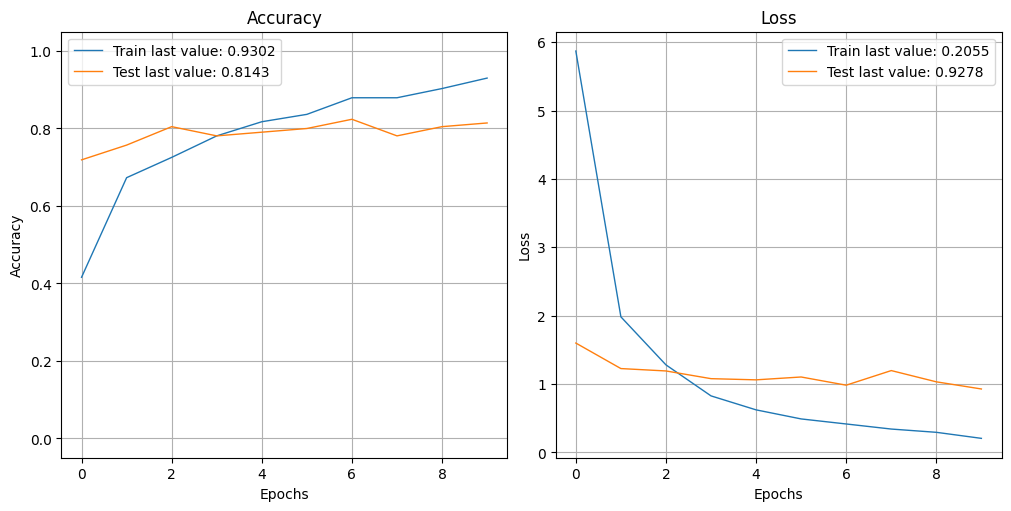

In [ ]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

**Interpretation du graphique**

Les graphiques montrent les performances du modèle au cours des epochs sur les ensembles d'entraînement et de validation (ou test) en termes d'accuracy et de loss.

**Analyse de l'Exactitude**

* **Exactitude d'entraînement :** On constate que l'exactitude d'entraînement augmente régulièrement à chaque époque et atteint une valeur finale d'environ 0.9159 . Cela signifie que le modèle apprend bien sur les données d'entraînement et parvient à distinguer correctement les classes.

* **Exactitude de test :** L'exactitude de test augmente également au début mais semble se stabiliser autour de 0.8095 . Ce résultat est inférieur à celui de l'entraînement, ce qui pourrait indiquer une certaine généralisation, mais aussi un léger risque de surapprentissage (overfitting).


**Analyse de la perte**

* **Perte d'entraînement :** La courbe de perte pour l'entraînement diminue de façon marquée au début, puis continue de baisser progressivement pour atteindre une valeur de 0,2228 à la fin des époques. Cette diminution soutenue de la perte montre que le modèle optimise bien ses paramètres pour les données d'entraînement.

* **Perte de test :** La perte de test diminue également au début, mais elle se stabilise aux alentours de 1.1080 et semble même légèrement augmenter vers la fin. Cette stagnation ou légère augmentation est généralement le signe que le modèle commence à trop se spécialiser aux données d'entraînement, ce qui pourrait mener à un surapprentissage.


*La différence entre la perte d'entraînement (0.2228) et la perte de test (1.1080) indique que le modèle commence à surapprendre.*

**comparer les classes prédites par le modèle avec les vraies classes dans un ensemble de validation (X_val, y_val)**

In [ ]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step
[3 6 2 6 3 5 4 0 0 2 6 0 1 5 6 3 1 1 6 0 1 2 6 3 3 0 4 4 2 0 2 4 6 5 0 6 4
 5 1 1 5 6 1 0 6 6 5 0 4 1 5 4 5 0 2 6 5 5 1 4 4 5 3 6 3 3 6 0 3 5 3 2 5 3
 3 3 2 6 1 5 3 4 2 0 3 5 2 5 3 4 3 4 6 1 2 5 0 4 6 3 5 1 1 5 3 1 1 1 2 2 3
 5 4 2 5 4 2 6 0 2 0 3 2 4 5 3 1 3 3 0 0 4 2 1 6 1 1 4 2 1 2 6 3 6 5 1 1 6
 6 0 0 5 3 4 3 3 5 1 3 1 4 5 6 5 0 4 0 6 1 0 4 0 2 1 4 0 2 4 0 5 2 4 0 1 0
 5 2 4 0 2 2 1 6 1 4 2 4 3 1 1 6 2 0 6 0 4 0 6 5 5]

[3 6 4 6 3 1 4 0 0 5 6 0 1 5 3 3 1 1 6 5 1 2 6 3 4 0 4 4 1 0 2 4 6 5 1 6 4
 5 1 1 5 6 1 1 6 6 1 0 2 1 3 4 5 0 1 6 5 5 1 4 4 1 1 6 3 3 6 0 3 5 5 2 5 5
 3 3 2 6 6 5 3 4 2 0 3 5 2 5 3 4 3 4 6 1 2 5 0 4 6 3 5 1 3 5 3 1 1 1 2 2 0
 5 4 2 5 4 2 6 0 2 3 3 2 4 5 3 1 5 3 0 0 4 2 1 6 1 1 4 2 2 3 6 3 6 5 1 1 6
 6 1 0 5 3 0 1 3 5 1 5 1 4 1 6 3 0 0 5 6 1 0 4 4 2 1 4 4 2 4 4 5 1 4 0 1 0
 5 1 0 0 5 2 1 6 1 4 2 4 3 1 1 6 2 0 6 0 4 0 6 5 5]


**Matrice de Confusion**

In [ ]:
# Utilisez confusion_matrix correctement
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)


[[22  3  0  1  3  2  0]
 [ 0 29  1  1  0  0  1]
 [ 0  4 20  1  1  2  0]
 [ 1  2  0 22  1  4  0]
 [ 3  0  1  0 25  0  0]
 [ 0  4  0  2  0 25  0]
 [ 0  0  0  1  0  0 28]]


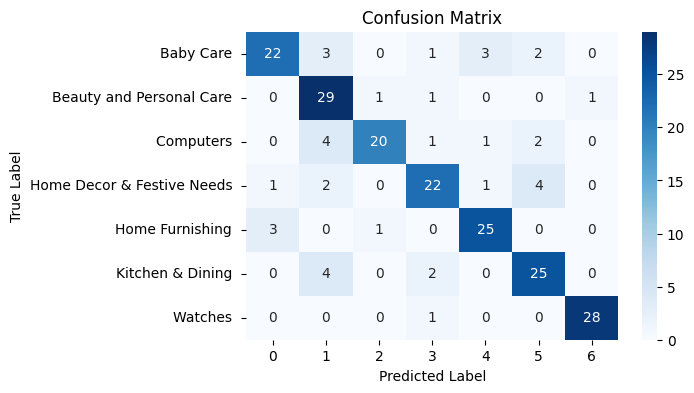


Classification Report:
                             precision    recall  f1-score   support

                 Baby Care        0.85      0.71      0.77        31
  Beauty and Personal Care        0.69      0.91      0.78        32
                 Computers        0.91      0.71      0.80        28
Home Decor & Festive Needs        0.79      0.73      0.76        30
           Home Furnishing        0.83      0.86      0.85        29
          Kitchen & Dining        0.76      0.81      0.78        31
                   Watches        0.97      0.97      0.97        29

                   accuracy                           0.81       210
                  macro avg       0.83      0.81      0.82       210
               weighted avg       0.82      0.81      0.81       210



In [ ]:
# Define labels for heatmap
list_labels = le.inverse_transform(np.unique(data_train['label']))  
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in range(conf_mat.shape[1])])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val_num, y_val_pred, target_names=list_labels))

**afficher les images de validation avec leurs prédictions et les étiquettes réelles**

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


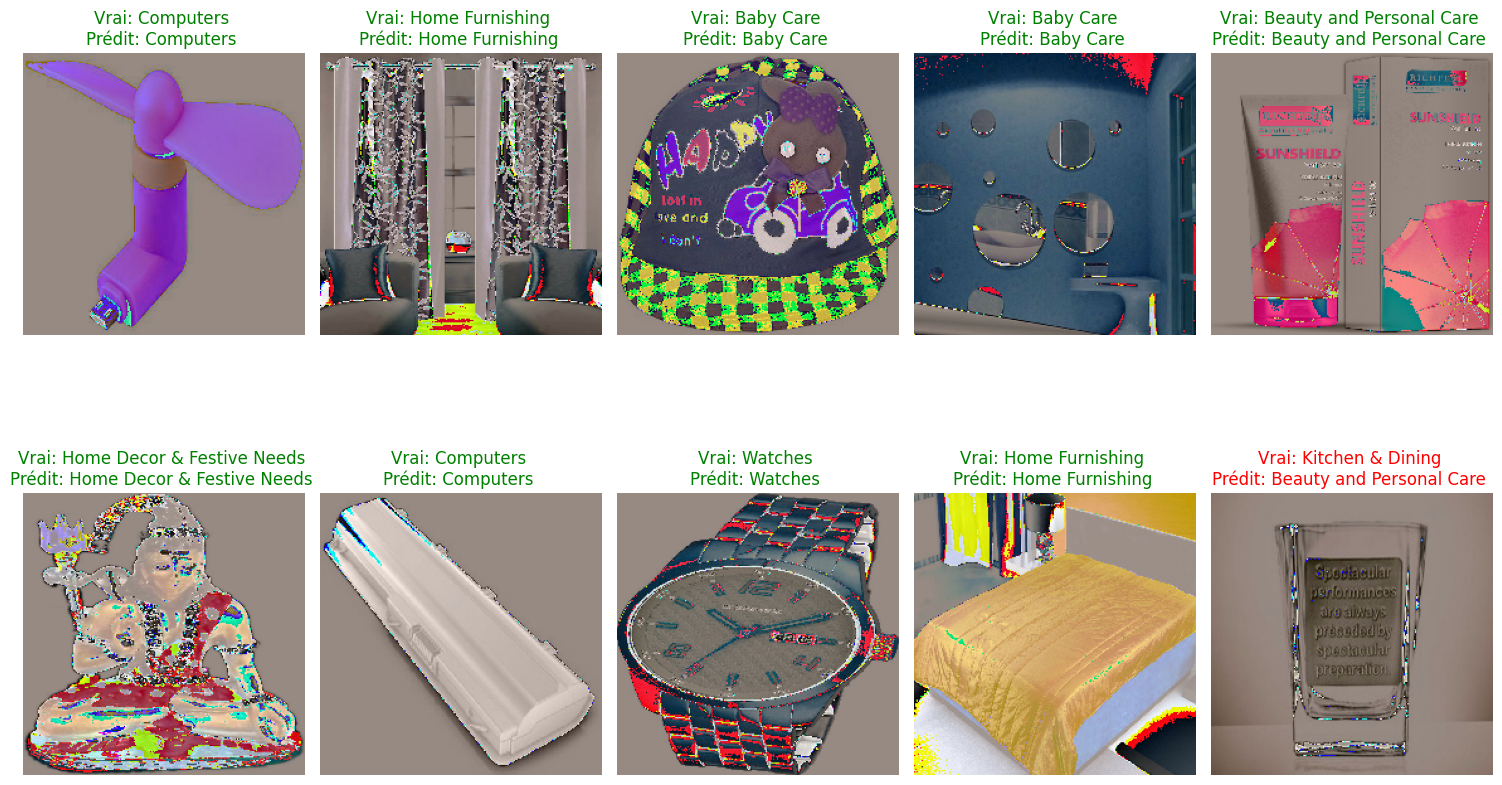

In [ ]:
def display_predictions(images, true_labels, pred_labels, label_names, num_samples=10):
    """
    Affiche les images avec l'étiquette réelle et la prédiction du modèle.

    :param images: Tableaux NumPy contenant les images.
    :param true_labels: Étiquettes réelles (numériques).
    :param pred_labels: Étiquettes prédites par le modèle (numériques).
    :param label_names: Liste des noms de catégories, correspondant aux étiquettes.
    :param num_samples: Nombre d'exemples à afficher.
    """
    plt.figure(figsize=(15, 10))
    indices = np.random.choice(range(len(images)), size=num_samples, replace=False)

    for i, index in enumerate(indices):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(images[index].astype("uint8"))
        plt.title(
            f"Vrai: {label_names[true_labels[index]]}\n"
            f"Prédit: {label_names[pred_labels[index]]}",
            color="green" if true_labels[index] == pred_labels[index] else "red"
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()



y_val_num = np.argmax(y_val, axis=1)  # Convertir en labels numériques
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

# Appeler la fonction avec les images de validation et les prédictions
display_predictions(X_val, y_val_num, y_val_pred, list_labels, num_samples=10)


# **Tester avec la data augmentation**

In [ ]:
# Préparer les images et labels pour l'entraînement et le test
X_train_images = image_prep_fct(data_train)
y_train = to_categorical(data_train['label'])
X_test_images = image_prep_fct(data_test)
y_test = to_categorical(data_test['label'])

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
# Division en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train, stratify=y_train, test_size=0.25, random_state=42)

In [ ]:
# Création du générateur de Data Augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rotation_range=20,         # rotation aléatoire des images entre -20 et 20 degrés
    width_shift_range=0.2,     # décalage horizontal aléatoire jusqu'à 20%
    height_shift_range=0.2,    # décalage vertical aléatoire jusqu'à 20%
    shear_range=0.15,          # cisaillement aléatoire des images
    zoom_range=0.15,           # zoom avant/arrière aléatoire
    horizontal_flip=True,      # inversion horizontale aléatoire
    fill_mode='nearest'        # mode de remplissage pour les pixels hors cadre
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [ ]:
# Générateur sans transformation pour la validation
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [ ]:
# Fonction de création du modèle avec VGG16
def create_model_fct():
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model0.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(model0.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    return model

In [ ]:
# Création et compilation du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

In [ ]:

# Création du callback pour sauvegarder le meilleur modèle
model1_save_path = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(model1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Entraîner le modèle avec les données augmentées
with tf.device('/gpu:0'):
    history1 = model1.fit(
        train_generator,
        epochs=10,
        callbacks=callbacks_list,
        validation_data=val_generator,
        verbose=1
    )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3131 - loss: 6.7222
Epoch 1: val_loss improved from inf to 1.64253, saving model to ./model1_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 920ms/step - accuracy: 0.3191 - loss: 6.6198 - val_accuracy: 0.7238 - val_loss: 1.6425
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.5790 - loss: 2.4310
Epoch 2: val_loss improved from 1.64253 to 1.47615, saving model to ./model1_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 679ms/step - accuracy: 0.5802 - loss: 2.4201 - val_accuracy: 0.7429 - val_loss: 1.4762
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7482 - loss: 1.2273
Epoch 3: val_loss improved from 1.47615 to 1.11072, saving model to ./model1_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 984ms/step - accuracy: 0.7476 - loss: 1.2299 - val_accuracy: 0.7905 - val_loss: 1.1107
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7728 - loss: 0.9530
Epoch 4: val_loss improved fr

In [ ]:
# Évaluation sur l'ensemble d'entraînement, validation et test
model1.load_weights(model1_save_path)
print("Validation Accuracy:", model1.evaluate(X_val, y_val, verbose=False)[1])
print("Test Accuracy:", model1.evaluate(X_test_images, y_test, verbose=False)[1])

Validation Accuracy: 0.8333333134651184
Test Accuracy: 0.8380952477455139


In [ ]:
# Prédictions sur l'ensemble de validation
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)
display(y_val_pred)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


array([3, 6, 4, 6, 3, 1, 0, 0, 5, 5, 6, 0, 1, 5, 1, 3, 1, 1, 6, 5, 1, 5,
       6, 3, 3, 0, 4, 4, 2, 0, 2, 4, 6, 5, 2, 6, 4, 5, 1, 1, 5, 6, 1, 1,
       6, 6, 1, 0, 1, 1, 3, 4, 5, 0, 2, 6, 5, 5, 1, 4, 4, 5, 5, 6, 3, 3,
       6, 0, 3, 5, 3, 2, 5, 5, 3, 3, 2, 6, 1, 5, 3, 4, 1, 4, 3, 5, 2, 5,
       3, 3, 3, 4, 6, 1, 2, 5, 0, 4, 5, 5, 5, 1, 3, 5, 3, 1, 1, 1, 2, 2,
       4, 5, 4, 2, 5, 4, 2, 6, 0, 2, 3, 3, 2, 4, 5, 3, 1, 3, 3, 0, 0, 4,
       2, 1, 6, 1, 1, 4, 2, 6, 2, 6, 3, 6, 5, 1, 1, 6, 6, 1, 0, 5, 3, 4,
       3, 3, 5, 1, 5, 1, 4, 1, 6, 3, 0, 4, 5, 6, 1, 0, 4, 4, 2, 1, 4, 3,
       2, 4, 4, 5, 2, 4, 3, 1, 0, 5, 1, 4, 5, 2, 2, 1, 6, 1, 4, 2, 4, 3,
       1, 1, 6, 2, 0, 6, 0, 4, 0, 6, 5, 5])

In [ ]:
display(y_val_true)

array([3, 6, 2, 6, 3, 5, 4, 0, 0, 2, 6, 0, 1, 5, 6, 3, 1, 1, 6, 0, 1, 2,
       6, 3, 3, 0, 4, 4, 2, 0, 2, 4, 6, 5, 0, 6, 4, 5, 1, 1, 5, 6, 1, 0,
       6, 6, 5, 0, 4, 1, 5, 4, 5, 0, 2, 6, 5, 5, 1, 4, 4, 5, 3, 6, 3, 3,
       6, 0, 3, 5, 3, 2, 5, 3, 3, 3, 2, 6, 1, 5, 3, 4, 2, 0, 3, 5, 2, 5,
       3, 4, 3, 4, 6, 1, 2, 5, 0, 4, 6, 3, 5, 1, 1, 5, 3, 1, 1, 1, 2, 2,
       3, 5, 4, 2, 5, 4, 2, 6, 0, 2, 0, 3, 2, 4, 5, 3, 1, 3, 3, 0, 0, 4,
       2, 1, 6, 1, 1, 4, 2, 1, 2, 6, 3, 6, 5, 1, 1, 6, 6, 0, 0, 5, 3, 4,
       3, 3, 5, 1, 3, 1, 4, 5, 6, 5, 0, 4, 0, 6, 1, 0, 4, 0, 2, 1, 4, 0,
       2, 4, 0, 5, 2, 4, 0, 1, 0, 5, 2, 4, 0, 2, 2, 1, 6, 1, 4, 2, 4, 3,
       1, 1, 6, 2, 0, 6, 0, 4, 0, 6, 5, 5])

In [ ]:
# Confusion matrix et rapport de classification
conf_mat = confusion_matrix(y_val_true, y_val_pred)
print("Confusion Matrix:\n", conf_mat)
print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred, target_names=le.inverse_transform(np.unique(data_train['label']))))

Confusion Matrix:
 [[18  2  1  3  3  4  0]
 [ 0 30  0  1  0  0  1]
 [ 0  2 23  0  1  2  0]
 [ 0  0  0 25  1  4  0]
 [ 1  1  0  1 26  0  0]
 [ 0  3  0  2  0 26  0]
 [ 0  1  0  0  0  1 27]]

Classification Report:
                              precision    recall  f1-score   support

                 Baby Care        0.95      0.58      0.72        31
  Beauty and Personal Care        0.77      0.94      0.85        32
                 Computers        0.96      0.82      0.88        28
Home Decor & Festive Needs        0.78      0.83      0.81        30
           Home Furnishing        0.84      0.90      0.87        29
          Kitchen & Dining        0.70      0.84      0.76        31
                   Watches        0.96      0.93      0.95        29

                   accuracy                           0.83       210
                  macro avg       0.85      0.83      0.83       210
               weighted avg       0.85      0.83      0.83       210



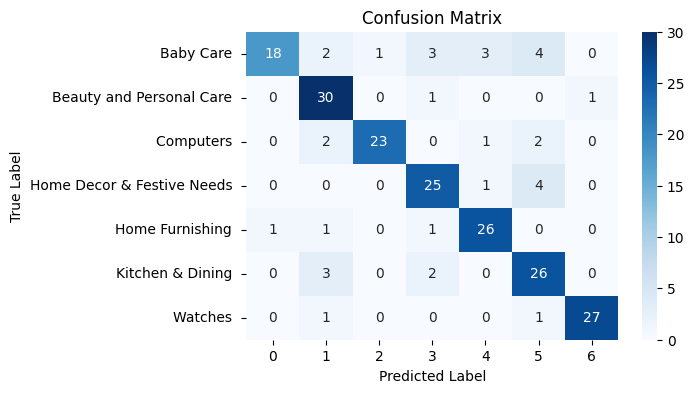

In [ ]:
# Affichage de la matrice de confusion avec heatmap
df_cm = pd.DataFrame(conf_mat, index=[label for label in le.inverse_transform(np.unique(data_train['label']))],
                     columns=[i for i in range(conf_mat.shape[1])])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

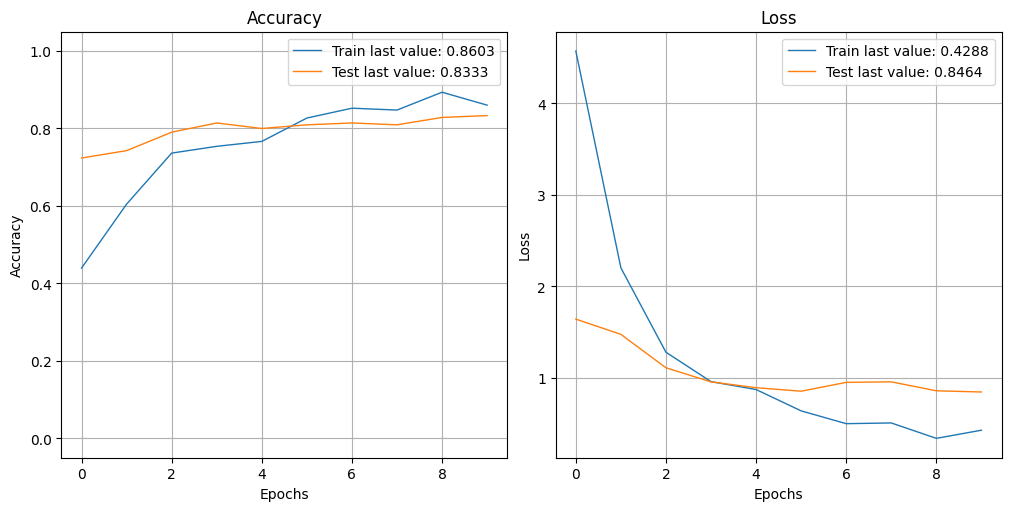

In [ ]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

* La data augmentation a permis de réduire le surapprentissage en augmentant la complexité des données d'entraînement, ce qui se reflète dans la légère diminution de l'exactitude d'entraînement et l'augmentation de la perte d'entraînement.

* L'exactitude de test et la perte de test montrent que le modèle est maintenant légèrement mieux adapté aux nouvelles données, confirmant une meilleure généralisation.

# **Tester en modifiant un paramètre comme le learning rate ou le dropout**

In [ ]:
# Préparer les images et labels pour l'entraînement et le test
X_train_images = image_prep_fct(data_train)
y_train = to_categorical(data_train['label'])
X_test_images = image_prep_fct(data_test)
y_test = to_categorical(data_test['label'])

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
# Division en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train, stratify=y_train, test_size=0.25, random_state=42)

In [ ]:


# Création du générateur de Data Augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

In [ ]:
# Générateur sans transformation pour la validation
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [ ]:
# Fonction de création du modèle VGG16 avec paramètres modifiables (learning rate et dropout)
def create_model_fct(learning_rate=0.0001, dropout_rate=0.5):
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model0.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(model0.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=model0.input, outputs=predictions)

    # Utilisation de l'optimiseur RMSprop avec un taux d'apprentissage modifiable
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
# Création et compilation des modèles avec différents paramètres
models = {
    'model_lr_0.0001_dr_0.5': create_model_fct(learning_rate=0.0001, dropout_rate=0.5),
    'model_lr_0.0001_dr_0.3': create_model_fct(learning_rate=0.0001, dropout_rate=0.3)
}

In [ ]:
histories = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...\n")

    # Création des callbacks
    checkpoint = ModelCheckpoint(f"{model_name}_best_weights.keras", monitor='val_loss', save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

    # Entraînement du modèle
    with tf.device('/gpu:0'):
        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=[checkpoint, es],
            verbose=1
        )
    histories[model_name] = history


Training model_lr_0.0001_dr_0.5...

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1365 - loss: 10.4823 - val_accuracy: 0.2905 - val_loss: 4.6401
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1931 - loss: 7.1384 - val_accuracy: 0.4238 - val_loss: 3.2135
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2669 - loss: 5.4117 - val_accuracy: 0.5000 - val_loss: 2.6700
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2936 - loss: 4.7142 - val_accuracy: 0.5619 - val_loss: 2.3656
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3904 - loss: 4.5725 - val_accuracy: 0.6000 - val_loss: 2.0470
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3499 - loss: 4.5583 - val_accuracy: 0.6286 - val_loss: 1.8309
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4164 - loss: 3.8421 - val_accuracy: 0.6381 - val_loss: 1.7166
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4849 - loss: 3.2792 - val_accuracy: 0.6667 - val_loss: 1.6391
Ep

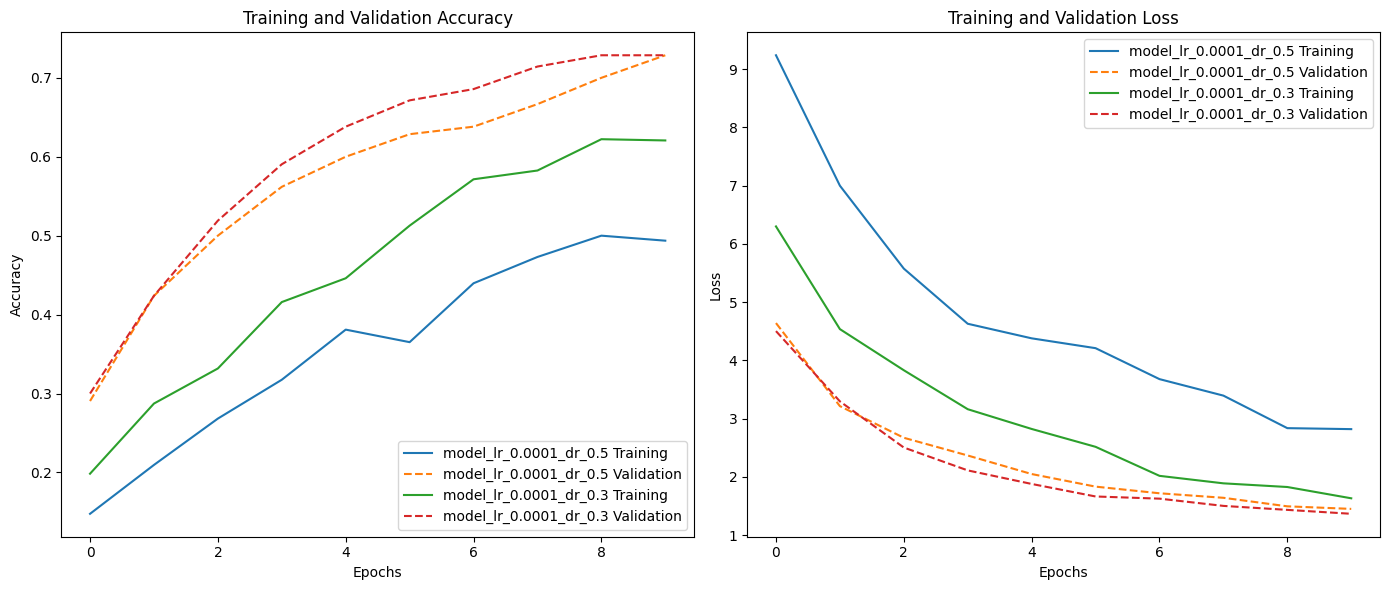

In [ ]:
# Fonction d'affichage des courbes d'entraînement et validation pour chaque modèle
def plot_training_histories(histories):
    plt.figure(figsize=(14, 6))

    # Affichage de la précision pour chaque modèle
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Training')
        plt.plot(history.history['val_accuracy'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Affichage de la perte pour chaque modèle
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Training')
        plt.plot(history.history['val_loss'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Appel de la fonction pour afficher les courbes
plot_training_histories(histories)

In [ ]:
# Évaluation sur l'ensemble de test pour chaque modèle
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} on the test set...")
    model.load_weights(f"{model_name}_best_weights.keras")
    test_loss, test_accuracy = model.evaluate(X_test_images, y_test, verbose=0)
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")

# Prédictions et matrice de confusion pour le modèle le plus performant 
best_model_name = 'model_lr_0.0001_dr_0.3'  
best_model = models[best_model_name]
best_model.load_weights(f"{best_model_name}_best_weights.keras")


Evaluating model_lr_0.0001_dr_0.5 on the test set...
Test Accuracy for model_lr_0.0001_dr_0.5: 0.6619

Evaluating model_lr_0.0001_dr_0.3 on the test set...
Test Accuracy for model_lr_0.0001_dr_0.3: 0.6905


In [ ]:
# Prédictions sur l'ensemble de validation
y_val_pred = np.argmax(best_model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


In [ ]:
y_val_pred

array([3, 6, 2, 6, 3, 3, 4, 0, 5, 4, 6, 0, 1, 5, 6, 3, 1, 1, 6, 5, 1, 5,
       6, 3, 4, 0, 4, 0, 2, 0, 2, 4, 6, 5, 2, 6, 1, 5, 1, 1, 5, 6, 1, 1,
       6, 2, 5, 4, 4, 0, 1, 4, 5, 0, 5, 6, 5, 5, 1, 6, 4, 2, 6, 6, 3, 3,
       6, 5, 3, 5, 2, 2, 5, 5, 3, 3, 2, 6, 6, 5, 5, 4, 2, 0, 3, 5, 2, 5,
       4, 3, 3, 4, 6, 1, 2, 5, 0, 4, 5, 6, 5, 1, 4, 5, 3, 1, 1, 1, 2, 5,
       4, 5, 4, 2, 5, 4, 2, 1, 0, 0, 2, 3, 1, 4, 5, 3, 1, 0, 3, 4, 0, 3,
       2, 1, 6, 2, 5, 4, 2, 5, 2, 6, 3, 6, 0, 1, 1, 6, 6, 1, 0, 5, 0, 4,
       3, 4, 5, 1, 5, 1, 0, 5, 6, 5, 0, 0, 6, 6, 1, 0, 4, 4, 2, 1, 4, 4,
       2, 4, 4, 5, 5, 4, 0, 1, 0, 4, 1, 4, 5, 6, 5, 1, 6, 1, 4, 2, 4, 3,
       1, 1, 6, 2, 0, 6, 0, 4, 0, 6, 5, 5])

In [ ]:
y_val_true

array([3, 6, 2, 6, 3, 5, 4, 0, 0, 2, 6, 0, 1, 5, 6, 3, 1, 1, 6, 0, 1, 2,
       6, 3, 3, 0, 4, 4, 2, 0, 2, 4, 6, 5, 0, 6, 4, 5, 1, 1, 5, 6, 1, 0,
       6, 6, 5, 0, 4, 1, 5, 4, 5, 0, 2, 6, 5, 5, 1, 4, 4, 5, 3, 6, 3, 3,
       6, 0, 3, 5, 3, 2, 5, 3, 3, 3, 2, 6, 1, 5, 3, 4, 2, 0, 3, 5, 2, 5,
       3, 4, 3, 4, 6, 1, 2, 5, 0, 4, 6, 3, 5, 1, 1, 5, 3, 1, 1, 1, 2, 2,
       3, 5, 4, 2, 5, 4, 2, 6, 0, 2, 0, 3, 2, 4, 5, 3, 1, 3, 3, 0, 0, 4,
       2, 1, 6, 1, 1, 4, 2, 1, 2, 6, 3, 6, 5, 1, 1, 6, 6, 0, 0, 5, 3, 4,
       3, 3, 5, 1, 3, 1, 4, 5, 6, 5, 0, 4, 0, 6, 1, 0, 4, 0, 2, 1, 4, 0,
       2, 4, 0, 5, 2, 4, 0, 1, 0, 5, 2, 4, 0, 2, 2, 1, 6, 1, 4, 2, 4, 3,
       1, 1, 6, 2, 0, 6, 0, 4, 0, 6, 5, 5])

In [ ]:
# Confusion matrix et rapport de classification
conf_mat = confusion_matrix(y_val_true, y_val_pred)
print(f"\nConfusion Matrix for {best_model_name}:\n", conf_mat)
print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred, target_names=le.inverse_transform(np.unique(data_train['label']))))


Confusion Matrix for model_lr_0.0001_dr_0.3:
 [[17  2  2  0  5  4  1]
 [ 1 26  1  0  1  2  1]
 [ 1  2 18  0  1  5  1]
 [ 2  0  1 18  4  3  2]
 [ 3  1  0  2 22  0  1]
 [ 1  1  1  1  1 26  0]
 [ 0  1  1  0  0  1 26]]

Classification Report:
                              precision    recall  f1-score   support

                 Baby Care        0.68      0.55      0.61        31
  Beauty and Personal Care        0.79      0.81      0.80        32
                 Computers        0.75      0.64      0.69        28
Home Decor & Festive Needs        0.86      0.60      0.71        30
           Home Furnishing        0.65      0.76      0.70        29
          Kitchen & Dining        0.63      0.84      0.72        31
                   Watches        0.81      0.90      0.85        29

                   accuracy                           0.73       210
                  macro avg       0.74      0.73      0.73       210
               weighted avg       0.74      0.73      0.73       21

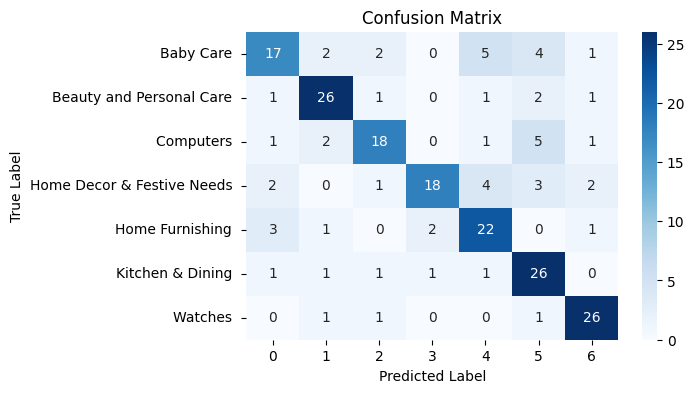

In [ ]:
# Affichage de la matrice de confusion avec heatmap
df_cm = pd.DataFrame(conf_mat, index=[label for label in le.inverse_transform(np.unique(data_train['label']))],
                     columns=[i for i in range(conf_mat.shape[1])])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **EfficientNet**

In [ ]:
# Préparer les images et labels pour l'entraînement et le test
X_train_images = image_prep_fct(data_train)
y_train = to_categorical(data_train['label'])
X_test_images = image_prep_fct(data_test)
y_test = to_categorical(data_test['label'])

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
# Division en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train, stratify=y_train, test_size=0.25, random_state=42)

In [ ]:
# Création du générateur de Data Augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [ ]:
# Générateur sans transformation pour la validation
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [ ]:
# Fonction de création du modèle EfficientNet avec paramètres modifiables (learning rate et dropout)
def create_model_fct(learning_rate=0.0001, dropout_rate=0.5):
    model0 = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model0.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(model0.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=model0.input, outputs=predictions)

    # Utilisation de l'optimiseur Adam avec un taux d'apprentissage modifiable
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
# Création et compilation des modèles avec différents paramètres
models = {
    'model_lr_0.0001_dr_0.5': create_model_fct(learning_rate=0.0001, dropout_rate=0.5),
    'model_lr_0.0001_dr_0.3': create_model_fct(learning_rate=0.0001, dropout_rate=0.3)
}

In [ ]:
histories = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...\n")

    # Création des callbacks
    checkpoint = ModelCheckpoint(f"{model_name}_best_weights.keras", monitor='val_loss', save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

    # Entraînement du modèle
    with tf.device('/gpu:0'):
        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=[checkpoint, es],
            verbose=1
        )
    histories[model_name] = history


Training model_lr_0.0001_dr_0.5...

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.1812 - loss: 1.9765 - val_accuracy: 0.5381 - val_loss: 1.6431
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 826ms/step - accuracy: 0.4373 - loss: 1.6471 - val_accuracy: 0.6857 - val_loss: 1.3409
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 633ms/step - accuracy: 0.5678 - loss: 1.3769 - val_accuracy: 0.7476 - val_loss: 1.1185
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 832ms/step - accuracy: 0.6710 - loss: 1.1599 - val_accuracy: 0.7714 - val_loss: 0.9551
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 744ms/step - accuracy: 0.7003 - loss: 1.0577 - val_accuracy: 0.8000 - val_loss: 0.8393
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 665ms/step - accuracy: 0.7640 - loss: 0.9089 - val_accuracy: 0.8000 - val_loss: 0.7626
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 845ms/step - accuracy: 0.7863 - loss: 0.7977 - val_accuracy: 0.8048 - val_loss: 0.7069
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 891ms/step - accuracy: 0.7693 - loss: 0.7573 - val_accuracy: 0.8143 -

In [ ]:
# Fonction d'affichage des courbes d'entraînement et validation pour chaque modèle
def plot_training_histories(histories):
    plt.figure(figsize=(14, 6))

    # Affichage de la précision pour chaque modèle
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Training')
        plt.plot(history.history['val_accuracy'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Affichage de la perte pour chaque modèle
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Training')
        plt.plot(history.history['val_loss'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Appel de la fonction pour afficher les courbes
plot_training_histories(histories)

In [ ]:
# Évaluation sur l'ensemble de test pour chaque modèle
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} on the test set...")
    model.load_weights(f"{model_name}_best_weights.keras")
    test_loss, test_accuracy = model.evaluate(X_test_images, y_test, verbose=0)
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")

In [ ]:
# Prédictions et matrice de confusion pour le modèle le plus performant 
best_model_name = 'model_lr_0.0001_dr_0.3'  
best_model = models[best_model_name]
best_model.load_weights(f"{best_model_name}_best_weights.keras")

In [ ]:
# Prédictions sur l'ensemble de validation
y_val_pred = np.argmax(best_model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)

In [ ]:
y_val_pred

In [ ]:
y_val_true

In [ ]:
# Confusion matrix et rapport de classification
conf_mat = confusion_matrix(y_val_true, y_val_pred)
print(f"\nConfusion Matrix for {best_model_name}:\n", conf_mat)
print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred, target_names=le.inverse_transform(np.unique(data_train['label']))))

In [ ]:
# Affichage de la matrice de confusion avec heatmap
df_cm = pd.DataFrame(conf_mat, index=[label for label in le.inverse_transform(np.unique(data_train['label']))],
                     columns=[i for i in range(conf_mat.shape[1])])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **Xception**

In [ ]:
from tensorflow.keras.applications import Xception

In [ ]:
# Création du générateur de Data Augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Générateur sans transformation pour la validation
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [ ]:
# Fonction de création du modèle Xception avec paramètres modifiables (learning rate et dropout)
def create_model_fct(learning_rate=0.0001, dropout_rate=0.5):
    base_model = Xception(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x) 

    model = Model(inputs=base_model.input, outputs=predictions)

    # Utilisation de l'optimiseur Adam avec un taux d'apprentissage modifiable
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Création et compilation des modèles avec différents paramètres
models = {
    'model_xception_lr_0.0001_dr_0.5': create_model_fct(learning_rate=0.0001, dropout_rate=0.5),
    'model_xception_lr_0.0001_dr_0.3': create_model_fct(learning_rate=0.0001, dropout_rate=0.3)
}

In [ ]:
histories = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...\n")

    # Création des callbacks
    checkpoint = ModelCheckpoint(f"{model_name}_best_weights.keras", monitor='val_loss', save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

    # Entraînement du modèle
    with tf.device('/gpu:0'):
        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=[checkpoint, es],
            verbose=1
        )
    histories[model_name] = history

In [ ]:
# Fonction d'affichage des courbes d'entraînement et validation pour chaque modèle
def plot_training_histories(histories):
    plt.figure(figsize=(14, 6))

    # Affichage de la précision pour chaque modèle
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Training')
        plt.plot(history.history['val_accuracy'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Affichage de la perte pour chaque modèle
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Training')
        plt.plot(history.history['val_loss'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Appel de la fonction pour afficher les courbes
plot_training_histories(histories)

In [ ]:
# Évaluation sur l'ensemble de test pour chaque modèle
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} on the test set...")
    model.load_weights(f"{model_name}_best_weights.keras")
    test_loss, test_accuracy = model.evaluate(X_test_images, y_test, verbose=0)
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")

In [ ]:
# Prédictions et matrice de confusion pour le modèle le plus performant 
best_model_name = 'model_xception_lr_0.0001_dr_0.3'  
best_model = models[best_model_name]
best_model.load_weights(f"{best_model_name}_best_weights.keras")

In [ ]:
# Prédictions sur l'ensemble de validation
y_val_pred = np.argmax(best_model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)

In [ ]:
y_val_pred

In [ ]:
y_val_true

In [ ]:
# Confusion matrix et rapport de classification
conf_mat = confusion_matrix(y_val_true, y_val_pred)
print(f"\nConfusion Matrix for {best_model_name}:\n", conf_mat)
print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred, target_names=le.inverse_transform(np.unique(data_train['label']))))

In [ ]:
# Affichage de la matrice de confusion avec heatmap
df_cm = pd.DataFrame(conf_mat, index=[label for label in le.inverse_transform(np.unique(data_train['label']))],
                     columns=[i for i in range(conf_mat.shape[1])])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#**ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
# Création du générateur de Data Augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [ ]:
# Générateur sans transformation pour la validation
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Fonction de création du modèle ResNet50 avec paramètres modifiables (learning rate et dropout)
def create_model_fct(learning_rate=0.0001, dropout_rate=0.5):
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=predictions)

    # Utilisation de l'optimiseur Adam avec un taux d'apprentissage modifiable
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
# Création et compilation des modèles avec différents paramètres
models = {
    'model_resnet50_lr_0.0001_dr_0.5': create_model_fct(learning_rate=0.0001, dropout_rate=0.5),
    'model_resnet50_lr_0.0001_dr_0.3': create_model_fct(learning_rate=0.0001, dropout_rate=0.3)
}

In [ ]:
histories = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...\n")

    # Création des callbacks
    checkpoint = ModelCheckpoint(f"{model_name}_best_weights.keras", monitor='val_loss', save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

    # Entraînement du modèle
    with tf.device('/gpu:0'):
        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=[checkpoint, es],
            verbose=1
        )
    histories[model_name] = history

In [ ]:
# Fonction d'affichage des courbes d'entraînement et validation pour chaque modèle
def plot_training_histories(histories):
    plt.figure(figsize=(14, 6))

    # Affichage de la précision pour chaque modèle
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Training')
        plt.plot(history.history['val_accuracy'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Affichage de la perte pour chaque modèle
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Training')
        plt.plot(history.history['val_loss'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Appel de la fonction pour afficher les courbes
plot_training_histories(histories)

In [ ]:
# Évaluation sur l'ensemble de test pour chaque modèle
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} on the test set...")
    model.load_weights(f"{model_name}_best_weights.keras")
    test_loss, test_accuracy = model.evaluate(X_test_images, y_test, verbose=0)
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")

In [ ]:
# Prédictions et matrice de confusion pour le modèle le plus performant 
best_model_name = 'model_resnet50_lr_0.0001_dr_0.3'  
best_model = models[best_model_name]
best_model.load_weights(f"{best_model_name}_best_weights.keras")

# Prédictions sur l'ensemble de validation
y_val_pred = np.argmax(best_model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)

In [ ]:
y_val_pred

In [ ]:
y_val_true

In [ ]:
# Confusion matrix et rapport de classification
conf_mat = confusion_matrix(y_val_true, y_val_pred)
print(f"\nConfusion Matrix for {best_model_name}:\n", conf_mat)
print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred, target_names=le.inverse_transform(np.unique(data_train['label']))))

In [ ]:
# Affichage de la matrice de confusion avec heatmap
df_cm = pd.DataFrame(conf_mat, index=[label for label in le.inverse_transform(np.unique(data_train['label']))],
                     columns=[i for i in range(conf_mat.shape[1])])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **Conclusion**


Dans ce notebook, nous avons exploré plusieurs techniques et paramètres pour entraîner un modèle de classification d'images en utilisant le réseau VGG16. Les expériences menées, incluant la data augmentation et l'ajustement des hyperparamètres (learning rate et dropout), nous ont permis d'obtenir des résultats intéressants en termes de généralisation et de réduction du surapprentissage.